In [90]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier 
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from datetime import datetime

import seaborn as sns
sns.set(style="darkgrid")
# plt.style.use('ggplot')
#local
from tadat.pipeline import plots
from tadat.core import data, vectorizer, features, helpers, embeddings

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
def get_mortality_dataset(df, path_out=None):
    df["EXPIRE"] = df["HOSPITAL_EXPIRE_FLAG"]
    df_mortality = df[["EXPIRE","TEXT","GENDER"]]
    if path_out:
        df_mortality.to_csv(path_out,index=False, sep="\t", header=False)
    return df_mortality

def get_readmissions_dataset(admissions_df, patients_df, path_out=None):
    data = []
    READMISSION_DELTA = float("inf")
    for _, patient in patients_df.iterrows():
        adm = admissions_df[admissions_df["SUBJECT_ID"] == patient["SUBJECT_ID"]]
        if len(adm) > 1:
            admission_times = list(adm.sort_values("ADMITTIME")["ADMITTIME"])
            for i in range(len(admission_times)-1):
                d1 = admission_times[i]
                d2 = admission_times[i+1]
                d1 = datetime.strptime(d1, "%Y-%m-%d %H:%M:%S")
                d2 = datetime.strptime(d2, "%Y-%m-%d %H:%M:%S")
                delta = d2 - d1
                if delta.days < READMISSION_DELTA:
                    data.append([1,patient["TEXT"],patient["GENDER"]])
                    break             
        else:
            data.append([0,patient["TEXT"],patient["GENDER"]])
    readm_df = pd.DataFrame(data, columns=["READMISSION","TEXT","GENDER"])
    if path_out:
        readm_df.to_csv(path_out,index=False, sep="\t", header=False)    
    return readm_df
    

def extract_patients(mimic_path, sample_size=None, path_out=None):
    all_notes = pd.read_csv(mimic_path+"NOTEEVENTS.CSV.gz")
    all_patients = pd.read_csv(mimic_path+"PATIENTS.CSV.gz")
    all_admissions = pd.read_csv(mimic_path+"ADMISSIONS.CSV.gz")
    #filter relevant columns
    notes = all_notes[["TEXT"]]
    notes["TEXT"] = notes["TEXT"].apply(lambda x: x.replace("\n","").replace("\t","").lower())
    patients = all_patients[["SUBJECT_ID","GENDER"]]
    admissions = all_admissions[["INSURANCE","LANGUAGE","RELIGION","ETHNICITY","HOSPITAL_EXPIRE_FLAG"]]
    #subsample?
    if sample_size:        
        patients = patients[:sample_size]
    #join dataframes
    patients = patients.join(admissions, how="inner", on="SUBJECT_ID",rsuffix="A_")
    patients = patients.join(notes, how="inner", on="SUBJECT_ID",rsuffix="N_")
    
    if path_out:
        patients.to_csv(path_out,index=False, sep="\t", header=False)    
    
    return patients
    

In [92]:
raw_data_path = "/Users/samir/Dev/resources/datasets/MIMIC/full/"
out_data_path = "/Users/samir/Dev/projects/MIMIC/DATA/input/"

## Extract Data

In [93]:
# PATIENT_SAMPLE_SIZE = 10000
# mini_patients = extract_patients(raw_data_path, PATIENT_SAMPLE_SIZE,out_data_path+"mini_patients.csv")
# mini_patients
col_names = ["SUBJECT_ID","GENDER","INSURANCE","LANGUAGE","RELIGION","ETHNICITY","HOSPITAL_EXPIRE_FLAG","TEXT"]
mini_patients = pd.read_csv(out_data_path+"mini_patients.csv", header=None, 
                            sep="\t", names=col_names)
mini_patients

,SUBJECT_ID,GENDER,INSURANCE,LANGUAGE,RELIGION,ETHNICITY,HOSPITAL_EXPIRE_FLAG,TEXT
0,249,F,Medicaid,NaN,NOT SPECIFIED,BLACK/AFRICAN AMERICAN,0,admission date: [**2149-6-2**] discharg...
1,250,F,Medicare,NaN,UNOBTAINABLE,UNKNOWN/NOT SPECIFIED,0,admission date: [**2149-9-2**] discharg...
2,251,M,Medicaid,NaN,PROTESTANT QUAKER,BLACK/AFRICAN AMERICAN,0,admission date: [**2193-1-8**] d...
3,252,M,Medicare,NaN,CATHOLIC,OTHER,0,admission date: [**2133-9-3**] d...
4,253,F,Private,NaN,NOT SPECIFIED,HISPANIC OR LATINO,0,admission date: [**2103-8-16**] discharge...
5,255,M,Medicaid,NaN,PROTESTANT QUAKER,UNKNOWN/NOT SPECIFIED,0,admission date: [**2196-4-27**] discharge...
6,256,M,Private,ENGL,NOT SPECIFIED,BLACK/AFRICAN AMERICAN,0,admission date: [**2113-5-10**] discharge...
7,257,F,Medicare,NaN,UNOBTAINABLE,UNKNOWN/NOT SPECIFIED,1,admission date: [**2158-1-5**] d...
8,258,F,Medicare,NaN,CATHOLIC,UNKNOWN/NOT SPECIFIED,0,admission date: [**2137-4-23**] discharge...
9,260,F,Medicare,NaN,OTHER,WHITE,0,admission date: [**2191-4-8**] discharge ...


In [94]:
df_mortality = get_mortality_dataset(mini_patients, out_data_path+"mini_mortality.csv")
df_mortality

,EXPIRE,TEXT,GENDER
0,0,admission date: [**2149-6-2**] discharg...,F
1,0,admission date: [**2149-9-2**] discharg...,F
2,0,admission date: [**2193-1-8**] d...,M
3,0,admission date: [**2133-9-3**] d...,M
4,0,admission date: [**2103-8-16**] discharge...,F
5,0,admission date: [**2196-4-27**] discharge...,M
6,0,admission date: [**2113-5-10**] discharge...,M
7,1,admission date: [**2158-1-5**] d...,F
8,0,admission date: [**2137-4-23**] discharge...,F
9,0,admission date: [**2191-4-8**] discharge ...,F


In [95]:
mimic_path = "/Users/samir/Dev/resources/datasets/MIMIC/full/"
all_admissions = pd.read_csv(mimic_path+"ADMISSIONS.CSV.gz")
all_admissions

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1
5,26,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,V-TACH,0,1
6,27,27,134931,2191-11-30 22:16:00,2191-12-03 14:45:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,CATHOLIC,NaN,WHITE,NaN,NaN,NEWBORN,0,1
7,28,28,162569,2177-09-01 07:15:00,2177-09-06 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
8,29,30,104557,2172-10-14 14:17:00,2172-10-19 14:37:00,NaN,URGENT,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,UNKNOWN/NOT SPECIFIED,NaN,NaN,UNSTABLE ANGINA\CATH,0,1
9,30,31,128652,2108-08-22 23:27:00,2108-08-30 15:00:00,2108-08-30 15:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,STATUS EPILEPTICUS,1,1


In [96]:
df_readm = get_readmissions_dataset(all_admissions, mini_patients, path_out=out_data_path+"/mini_readmissions.csv")
df_readm

,READMISSION,TEXT,GENDER
0,1,admission date: [**2149-6-2**] discharg...,F
1,0,admission date: [**2149-9-2**] discharg...,F
2,0,admission date: [**2193-1-8**] d...,M
3,1,admission date: [**2133-9-3**] d...,M
4,0,admission date: [**2103-8-16**] discharge...,F
5,0,admission date: [**2196-4-27**] discharge...,M
6,1,admission date: [**2113-5-10**] discharge...,M
7,0,admission date: [**2158-1-5**] d...,F
8,0,admission date: [**2137-4-23**] discharge...,F
9,0,admission date: [**2191-4-8**] discharge ...,F


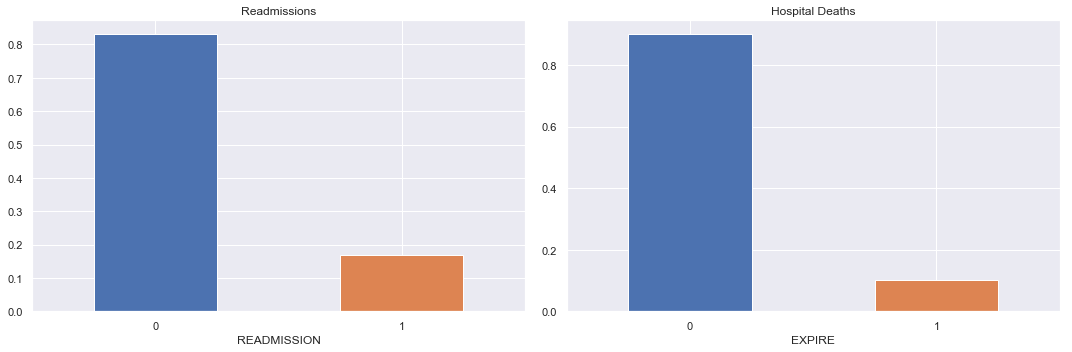

In [97]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
df_ag = df_readm.groupby("READMISSION").size()/df_readm.groupby("READMISSION").size().sum()
df_ag.plot(ax=ax[0],kind="bar", title="Readmissions", rot=0)

df_mg = df_mortality.groupby("EXPIRE").size()/df_mortality.groupby("EXPIRE").size().sum()
df_mg.plot(ax=ax[1],kind="bar", title="Hospital Deaths", rot=0)
plt.tight_layout()

In [98]:
#subsample majority class (negative)
RATIO = 1
readm_positive_size = df_readm.groupby("READMISSION").size()[1]
mort_positive_size = df_mortality.groupby("EXPIRE").size()[1]

readm_negative_size = int(readm_positive_size * RATIO)
mort_negative_size = int(mort_positive_size * RATIO)

all_readm_size = readm_positive_size + readm_negative_size
all_mort_size = mort_positive_size + mort_negative_size
print("Readmissions > Pos: {}/{} | Neg: {}/{}".format(readm_positive_size,all_readm_size,
                                                      readm_negative_size,all_readm_size))
print("   Mortality > Pos: {}/{} | Neg: {}/{}".format(mort_positive_size,all_mort_size,
                                   mort_negative_size,all_mort_size))

df_readm_neg = df_readm[df_readm["READMISSION"] == 0].head(readm_negative_size)
df_readm_pos = df_readm[df_readm["READMISSION"] == 1]
df_readm_all = df_readm_neg.append(df_readm_pos, ignore_index=True)

df_mortality_neg = df_mortality[df_mortality["EXPIRE"] == 0].head(mort_negative_size)
df_mortality_pos = df_mortality[df_mortality["EXPIRE"] == 1]
df_mortality_all = df_mortality_neg.append(df_mortality_pos, ignore_index=True)

df_mortality_all.to_csv(out_data_path+"/mini_mortality_balanced.csv",index=False, sep="\t", header=False)
df_readm_all.to_csv(out_data_path+"/mini_readmissions_balanced.csv",index=False, sep="\t", header=False)


Readmissions > Pos: 1696/3392 | Neg: 1696/3392
   Mortality > Pos: 1001/2002 | Neg: 1001/2002


## Read Data

In [99]:
df_mortality = pd.read_csv(out_data_path+"mini_mortality_balanced.csv",sep="\t", header=None, names=["EXPIRE","TEXT","GENDER"])
df_mortality 

,EXPIRE,TEXT,GENDER
0,0,admission date: [**2149-6-2**] discharg...,F
1,0,admission date: [**2149-9-2**] discharg...,F
2,0,admission date: [**2193-1-8**] d...,M
3,0,admission date: [**2133-9-3**] d...,M
4,0,admission date: [**2103-8-16**] discharge...,F
5,0,admission date: [**2196-4-27**] discharge...,M
6,0,admission date: [**2113-5-10**] discharge...,M
7,0,admission date: [**2137-4-23**] discharge...,F
8,0,admission date: [**2191-4-8**] discharge ...,F
9,0,admission date: [**2100-8-8**] d...,M


In [100]:
df_readmission = pd.read_csv(out_data_path+"mini_readmissions_balanced.csv",sep="\t", header=None, names=["READMISSION","TEXT","GENDER"])
df_readmission

,READMISSION,TEXT,GENDER
0,0,admission date: [**2149-9-2**] discharg...,F
1,0,admission date: [**2193-1-8**] d...,M
2,0,admission date: [**2103-8-16**] discharge...,F
3,0,admission date: [**2196-4-27**] discharge...,M
4,0,admission date: [**2158-1-5**] d...,F
5,0,admission date: [**2137-4-23**] discharge...,F
6,0,admission date: [**2191-4-8**] discharge ...,F
7,0,admission date: [**2100-8-8**] d...,M
8,0,admission date: [**2132-12-3**] dischar...,M
9,0,admission date: [**2150-2-3**] d...,M


## Analytics

In [110]:
def vectorize_data(train_split, test_split_M, test_split_F):
    #vectorize instances
    train_X = data.getX(train_split)
    test_X_M = data.getX(test_split_M)
    test_X_F = data.getX(test_split_F)
    
    train_X, word_vocab = vectorizer.docs2idx(train_X)
    test_X_M,_ = vectorizer.docs2idx(test_X_M, word_vocab)
    test_X_F,_ = vectorizer.docs2idx(test_X_F, word_vocab)
    #vectorize labels
    train_Y = data.getY(train_split)
    test_Y_M = data.getY(test_split_M) 
    test_Y_F = data.getY(test_split_F)    
    label_vocab = vectorizer.get_labels_vocab(train_Y+test_Y_M+test_Y_F)
    train_Y,_ = vectorizer.label2idx(train_Y, label_vocab)
    test_Y_M,_ = vectorizer.label2idx(test_Y_M, label_vocab)
    test_Y_F,_ = vectorizer.label2idx(test_Y_F, label_vocab)
    
    return train_X, train_Y, test_X_M, test_Y_M, test_X_F, test_Y_F, word_vocab, label_vocab

def get_features(data, vocab_size, feature_type, word_vectors=None):
    if feature_type == "BOW-bin":
        X = features.BOW(data, vocab_size,sparse=True)
    elif feature_type == "BOW-freq":
        X = features.BOW_freq(data, vocab_size,sparse=True)
    elif feature_type == "BOE-bin":
        X = features.BOE(data, word_vectors,"bin")
    elif feature_type == "BOE-sum": 
        X = features.BOE(data, word_vectors,"sum")
    else:
        raise NotImplementedError
    return X
    

def evaluate_classifier(X_train, Y_train, X_test, Y_test,
                   labels, model_name, random_seed=1234, res_path=None):
    model = SGDClassifier(random_state=random_seed)
    model.fit(X_train,Y_train)
    Y_hat = model.predict(X_test)
    microF1 = f1_score(Y_test, Y_hat, average="micro") 
    macroF1 = f1_score(Y_test, Y_hat, average="macro") 
    acc = accuracy_score(Y_test, Y_hat)
    precision, recall, fscore, support = score(Y_test, Y_hat)

    res = {"model":model_name, \
            "seed":random_seed, \
            "acc":round(acc,3), \
            "microF1":round(microF1,3), \
            "macroF1":round(macroF1,3)
            }

    for l, i in labels.items():
        res["{}-f1".format(l)] = round(fscore[i],3)
    helpers.print_results(res)
    if res_path is not None:
        cols = ["dataset", "model", "acc", "avgF1"]
        # helpers.save_results(res, res_path, sep="\t", columns=cols)
        helpers.save_results(res, res_path, sep="\t")
    return res

def run(df, x_label, y_label, feature_type, embeddings_path=None, split=0.8):
    #split into training and test sets
    train_split, test_split = data.shuffle_split_idx(df[y_label], split)
    df_train = df.iloc[train_split,:]
    df_test = df.iloc[test_split,:]
    df_test_M = df_test[df_test["GENDER"] == "M"]
    df_test_F = df_test[df_test["GENDER"] == "F"]

    #transform the data into the right format
    train = data.read_dataframe(df_train, x_label, y_label)
    test_M = data.read_dataframe(df_test_M, x_label, y_label)
    test_F = data.read_dataframe(df_test_F, x_label, y_label)
    
    #get vectorized train/test data 
    train_X, train_Y, test_X_M, test_Y_M, test_X_F, test_Y_F, word_vocab, label_vocab = vectorize_data(train, test_M, test_F)
    #extract features
    if "BOE" in feature_type:
        assert embeddings_path, "Missing embeddings path"
        #get embeddings     
        E, _ = embeddings.read_embeddings(embeddings_path, word_vocab, "latin-1")
        #get embedding features    
        train_feats = get_features(train_X, len(word_vocab), feature_type, E)
        test_feats_M = get_features(test_X_M, len(word_vocab), feature_type, E)
        test_feats_F = get_features(test_X_F, len(word_vocab), feature_type, E)
    else:
        train_feats = get_features(train_X, len(word_vocab), feature_type)
        test_feats_M = get_features(test_X_M, len(word_vocab), feature_type)
        test_feats_F = get_features(test_X_F, len(word_vocab), feature_type)

    #train/test classifier for each random seed
    random_seeds = list(range(20))
    results_m = []
    results_f = []
    for r in random_seeds:
        print("[running seed: {}]".format(r))
        res_m = evaluate_classifier(train_feats, train_Y, test_feats_M, test_Y_M, label_vocab, feature_type, r)
        results_m.append(res_m)
        res_f = evaluate_classifier(train_feats, train_Y, test_feats_F, test_Y_F, label_vocab, feature_type, r)
        results_f.append(res_f)
    return results_m, results_f



## Mortality

In [102]:
embeddings_path = "/Users/samir/Dev/resources/embeddings/word_embeddings.txt"
df = df_mortality
x_label = "TEXT"
y_label = "EXPIRE"
results_BOW_M, results_BOW_F = run(df, x_label, y_label, "BOW-bin", split=0.8)
results_BOW_freq_M, results_BOW_freq_F = run(df, x_label, y_label, "BOW-freq", split=0.8)


(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
** model: BOW-bin| seed: 0| acc: 0.5| microF1: 0.5| macroF1: 0.5| 0-f1: 0.496| 1-f1: 0.504| 
** model: BOW-bin| seed: 0| acc: 0.488| microF1: 0.488| macroF1: 0.484| 0-f1: 0.443| 1-f1: 0.526| 
[running seed: 1]
** model: BOW-bin| seed: 1| acc: 0.538| microF1: 0.538| macroF1: 0.537| 0-f1: 0.519| 1-f1: 0.554| 
** model: BOW-bin| seed: 1| acc: 0.531| microF1: 0.531| macroF1: 0.525| 0-f1: 0.472| 1-f1: 0.578| 
[running seed: 2]
** model: BOW-bin| seed: 2| acc: 0.496| microF1: 0.496| macroF1: 0.438| 0-f1: 0.258| 1-f1: 0.618| 
** model: BOW-bin| seed: 2| acc: 0.543| microF1: 0.543| macroF1: 0.481| 0-f1: 0.302| 1-f1: 0.661| 
[running seed: 3]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


** model: BOW-bin| seed: 3| acc: 0.479| microF1: 0.479| macroF1: 0.443| 0-f1: 0.302| 1-f1: 0.585| 
** model: BOW-bin| seed: 3| acc: 0.537| microF1: 0.537| macroF1: 0.502| 0-f1: 0.37| 1-f1: 0.634| 
[running seed: 4]
** model: BOW-bin| seed: 4| acc: 0.496| microF1: 0.496| macroF1: 0.493| 0-f1: 0.529| 1-f1: 0.457| 
** model: BOW-bin| seed: 4| acc: 0.537| microF1: 0.537| macroF1: 0.536| 0-f1: 0.561| 1-f1: 0.51| 
[running seed: 5]
** model: BOW-bin| seed: 5| acc: 0.479| microF1: 0.479| macroF1: 0.479| 0-f1: 0.486| 1-f1: 0.473| 
** model: BOW-bin| seed: 5| acc: 0.549| microF1: 0.549| macroF1: 0.547| 0-f1: 0.517| 1-f1: 0.578| 
[running seed: 6]
** model: BOW-bin| seed: 6| acc: 0.517| microF1: 0.517| macroF1: 0.517| 0-f1: 0.508| 1-f1: 0.525| 
** model: BOW-bin| seed: 6| acc: 0.488| microF1: 0.488| macroF1: 0.483| 0-f1: 0.435| 1-f1: 0.531| 
[running seed: 7]
** model: BOW-bin| seed: 7| acc: 0.467| microF1: 0.467| macroF1: 0.388| 0-f1: 0.169| 1-f1: 0.607| 
** model: BOW-bin| seed: 7| acc: 0.543|

/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for

** model: BOW-freq| seed: 5| acc: 0.475| microF1: 0.475| macroF1: 0.412| 0-f1: 0.22| 1-f1: 0.605| 
[running seed: 6]
** model: BOW-freq| seed: 6| acc: 0.521| microF1: 0.521| macroF1: 0.488| 0-f1: 0.618| 1-f1: 0.358| 
** model: BOW-freq| seed: 6| acc: 0.519| microF1: 0.519| macroF1: 0.506| 0-f1: 0.585| 1-f1: 0.426| 
[running seed: 7]
** model: BOW-freq| seed: 7| acc: 0.467| microF1: 0.467| macroF1: 0.375| 0-f1: 0.135| 1-f1: 0.614| 
** model: BOW-freq| seed: 7| acc: 0.525| microF1: 0.525| macroF1: 0.433| 0-f1: 0.206| 1-f1: 0.661| 
[running seed: 8]
** model: BOW-freq| seed: 8| acc: 0.533| microF1: 0.533| macroF1: 0.403| 0-f1: 0.682| 1-f1: 0.125| 
** model: BOW-freq| seed: 8| acc: 0.494| microF1: 0.494| macroF1: 0.369| 0-f1: 0.65| 1-f1: 0.089| 
[running seed: 9]
** model: BOW-freq| seed: 9| acc: 0.454| microF1: 0.454| macroF1: 0.448| 0-f1: 0.391| 1-f1: 0.506| 
** model: BOW-freq| seed: 9| acc: 0.5| microF1: 0.5| macroF1: 0.49| 0-f1: 0.417| 1-f1: 0.562| 
[running seed: 10]
** model: BOW-fr

## Results

In [103]:
#resuts
df_bb_M = pd.DataFrame(results_BOW_M)
df_bb_F = pd.DataFrame(results_BOW_F)
df_bf_M = pd.DataFrame(results_BOW_freq_M)
df_bf_F = pd.DataFrame(results_BOW_freq_F)
#compute deltas
df_bb_Delta = df_bb_M.sub(df_bb_F.iloc[:,0:5])
df_bb_Delta["model"] = df_bb_M["model"]
df_bb_Delta["seed"] = df_bb_M["seed"]
df_bf_Delta = df_bf_M.sub(df_bf_F.iloc[:,0:5])
df_bf_Delta["model"] = df_bf_M["model"]
df_bf_Delta["seed"] = df_bf_M["seed"]
#transform results into "long format"
df_bb_Delta_long = df_bb_Delta.melt(id_vars=["seed","model"], value_vars=["microF1","macroF1","0-f1","1-f1"], 
                                    var_name="metric", value_name="delta")

df_bf_Delta_long = df_bf_Delta.melt(id_vars=["seed","model"], value_vars=["microF1","macroF1","0-f1","1-f1"], 
                                    var_name="metric", value_name="delta")

df_delta_long = df_bb_Delta_long.append(df_bf_Delta_long)

Text(0.5,1.01,'Results per seed')

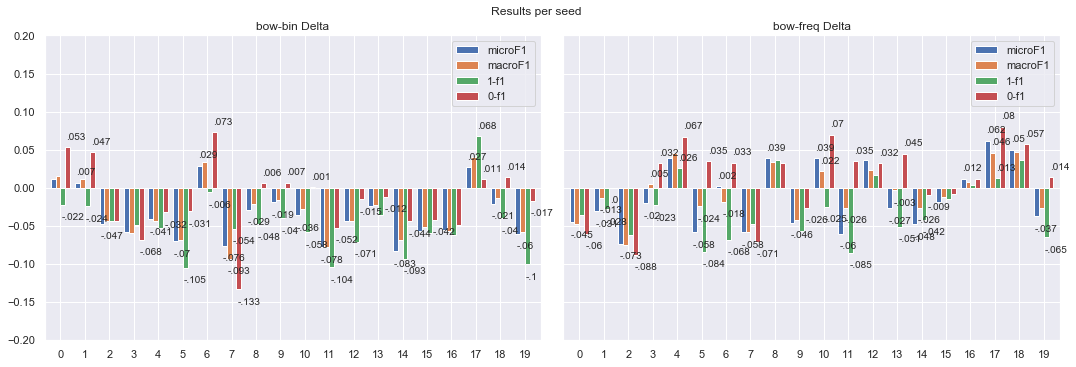

In [104]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,5))

plots.plot_df(df=df_bb_Delta,ax=ax[0],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=0.2, min_y=-0.2)
plots.plot_df(df=df_bf_Delta,ax=ax[1],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=0.2, min_y=-0.2)

ax[0].set_title("bow-bin Delta")
ax[1].set_title("bow-freq Delta")
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.tight_layout()
fig.suptitle("Results per seed",y=1.01)

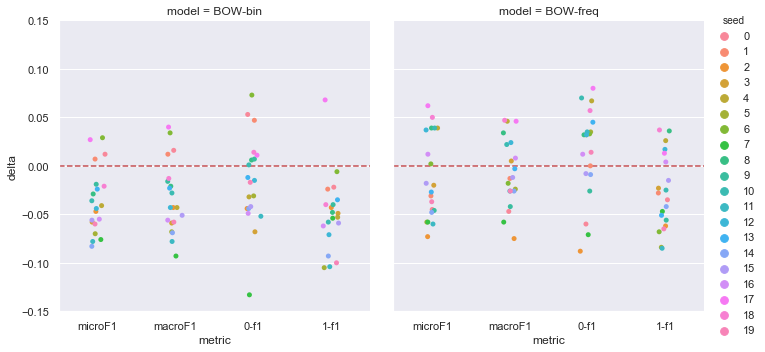

In [105]:
g = sns.catplot(x="metric", y="delta", hue="seed", data=df_delta_long, col="model")
ax1, ax2 = g.axes[0]
ax1.axhline(0, ls='--',c="r")
ax2.axhline(0, ls='--',c="r")
ax1.set_ylim([-0.15,0.15])
ax2.set_ylim([-0.15,0.15])
g

## Readmissions

In [106]:
embeddings_path = "/Users/samir/Dev/resources/embeddings/word_embeddings.txt"
df = df_readmission
x_label = "TEXT"
y_label = "READMISSION"

results_BOW_M, results_BOW_F = run(df, x_label, y_label, "BOW-bin", split=0.8)
results_BOW_freq_M, results_BOW_freq_F = run(df, x_label, y_label, "BOW-freq", split=0.8)


(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
** model: BOW-bin| seed: 0| acc: 0.545| microF1: 0.545| macroF1: 0.538| 0-f1: 0.485| 1-f1: 0.592| 
** model: BOW-bin| seed: 0| acc: 0.477| microF1: 0.477| macroF1: 0.465| 0-f1: 0.386| 1-f1: 0.544| 
[running seed: 1]
** model: BOW-bin| seed: 1| acc: 0.555| microF1: 0.555| macroF1: 0.555| 0-f1: 0.55| 1-f1: 0.56| 
** model: BOW-bin| seed: 1| acc: 0.466| microF1: 0.466| macroF1: 0.466| 0-f1: 0.457| 1-f1: 0.475| 
[running seed: 2]
** model: BOW-bin| seed: 2| acc: 0.563| microF1: 0.563| macroF1: 0.561| 0-f1: 0.59| 1-f1: 0.532| 
** model: BOW-bin| seed: 2| acc: 0.52| microF1: 0.52| macroF1: 0.517| 0-f1: 0.555| 1-f1: 0.48| 
[running seed: 3]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


** model: BOW-bin| seed: 3| acc: 0.568| microF1: 0.568| macroF1: 0.563| 0-f1: 0.61| 1-f1: 0.516| 
** model: BOW-bin| seed: 3| acc: 0.46| microF1: 0.46| macroF1: 0.449| 0-f1: 0.525| 1-f1: 0.374| 
[running seed: 4]
** model: BOW-bin| seed: 4| acc: 0.55| microF1: 0.55| macroF1: 0.549| 0-f1: 0.563| 1-f1: 0.535| 
** model: BOW-bin| seed: 4| acc: 0.456| microF1: 0.456| macroF1: 0.453| 0-f1: 0.494| 1-f1: 0.413| 
[running seed: 5]
** model: BOW-bin| seed: 5| acc: 0.555| microF1: 0.555| macroF1: 0.55| 0-f1: 0.5| 1-f1: 0.599| 
** model: BOW-bin| seed: 5| acc: 0.483| microF1: 0.483| macroF1: 0.467| 0-f1: 0.374| 1-f1: 0.56| 
[running seed: 6]
** model: BOW-bin| seed: 6| acc: 0.586| microF1: 0.586| macroF1: 0.586| 0-f1: 0.586| 1-f1: 0.586| 
** model: BOW-bin| seed: 6| acc: 0.5| microF1: 0.5| macroF1: 0.5| 0-f1: 0.484| 1-f1: 0.515| 
[running seed: 7]
** model: BOW-bin| seed: 7| acc: 0.579| microF1: 0.579| macroF1: 0.571| 0-f1: 0.517| 1-f1: 0.626| 
** model: BOW-bin| seed: 7| acc: 0.473| microF1: 0.4

/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for

** model: BOW-freq| seed: 17| acc: 0.5| microF1: 0.5| macroF1: 0.333| 0-f1: 0.0| 1-f1: 0.667| 
** model: BOW-freq| seed: 17| acc: 0.5| microF1: 0.5| macroF1: 0.333| 0-f1: 0.0| 1-f1: 0.667| 
[running seed: 18]
** model: BOW-freq| seed: 18| acc: 0.518| microF1: 0.518| macroF1: 0.419| 0-f1: 0.659| 1-f1: 0.179| 
** model: BOW-freq| seed: 18| acc: 0.483| microF1: 0.483| macroF1: 0.366| 0-f1: 0.638| 1-f1: 0.094| 
[running seed: 19]
** model: BOW-freq| seed: 19| acc: 0.521| microF1: 0.521| macroF1: 0.48| 0-f1: 0.626| 1-f1: 0.335| 
** model: BOW-freq| seed: 19| acc: 0.466| microF1: 0.466| macroF1: 0.412| 0-f1: 0.591| 1-f1: 0.232| 


## Results

In [107]:
#resuts
df_bb_M = pd.DataFrame(results_BOW_M)
df_bb_F = pd.DataFrame(results_BOW_F)
df_bf_M = pd.DataFrame(results_BOW_freq_M)
df_bf_F = pd.DataFrame(results_BOW_freq_F)
#compute deltas
df_bb_Delta = df_bb_M.sub(df_bb_F.iloc[:,0:5])
df_bb_Delta["model"] = df_bb_M["model"]
df_bb_Delta["seed"] = df_bb_M["seed"]
df_bf_Delta = df_bf_M.sub(df_bf_F.iloc[:,0:5])
df_bf_Delta["model"] = df_bf_M["model"]
df_bf_Delta["seed"] = df_bf_M["seed"]
#transform results into "long format"
df_bb_Delta_long = df_bb_Delta.melt(id_vars=["seed","model"], value_vars=["microF1","macroF1","0-f1","1-f1"], 
                                    var_name="metric", value_name="delta")

df_bf_Delta_long = df_bf_Delta.melt(id_vars=["seed","model"], value_vars=["microF1","macroF1","0-f1","1-f1"], 
                                    var_name="metric", value_name="delta")

df_delta_long = df_bb_Delta_long.append(df_bf_Delta_long)

Text(0.5,1.01,'Results per seed')

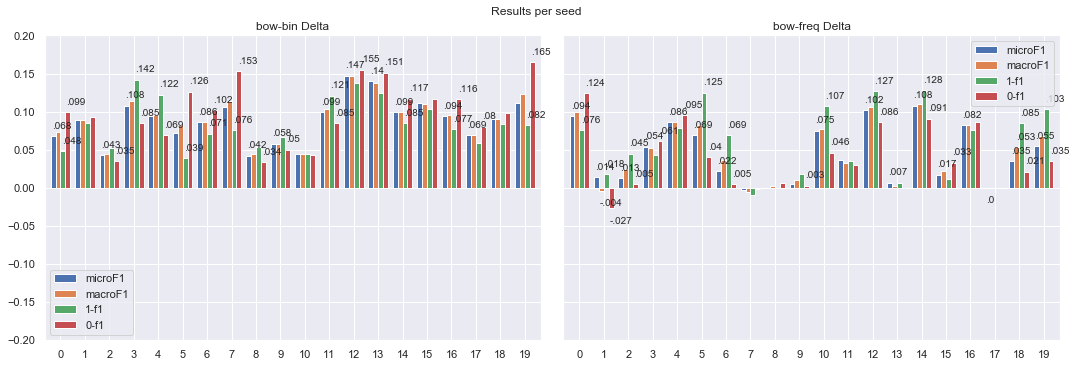

In [108]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,5))

plots.plot_df(df=df_bb_Delta,ax=ax[0],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=0.2, min_y=-0.2)
plots.plot_df(df=df_bf_Delta,ax=ax[1],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=0.2, min_y=-0.2)

ax[0].set_title("bow-bin Delta")
ax[1].set_title("bow-freq Delta")
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.tight_layout()
fig.suptitle("Results per seed",y=1.01)

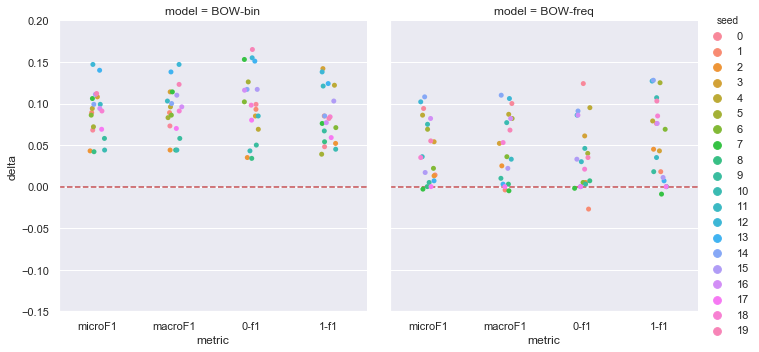

In [109]:
g = sns.catplot(x="metric", y="delta", hue="seed", data=df_delta_long, col="model")
ax1, ax2 = g.axes[0]
ax1.axhline(0, ls='--',c="r")
ax2.axhline(0, ls='--',c="r")
ax1.set_ylim([-0.15,0.2])
ax2.set_ylim([-0.15,0.2])
g